# Analysis Notebook

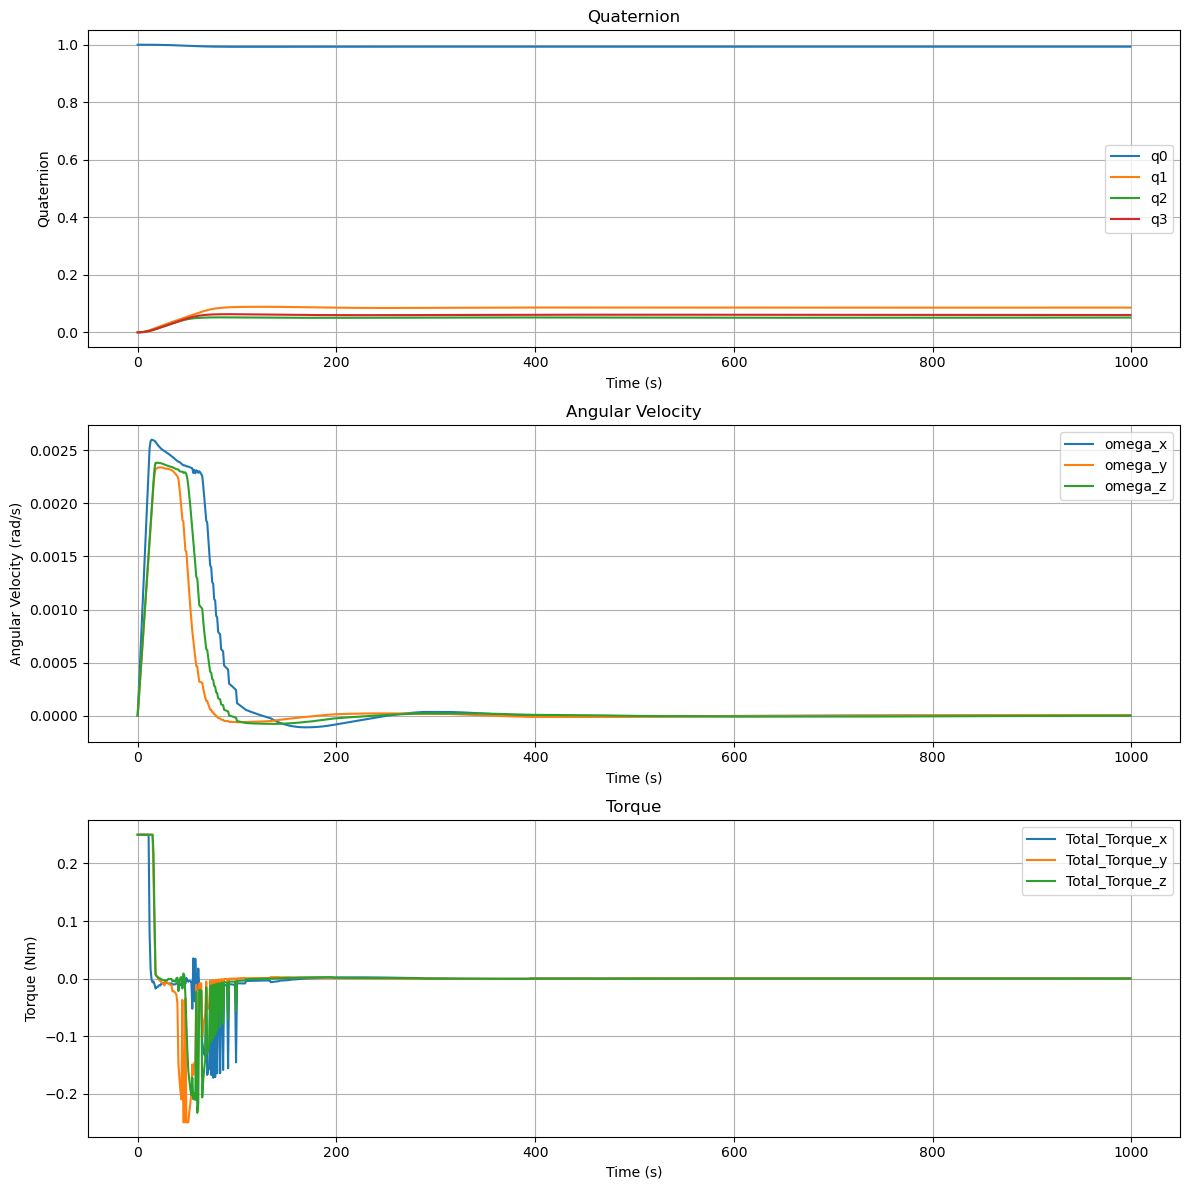

In [8]:
#plotting the three figures from csv file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load the data from the CSV file
data = pd.read_csv('satellite_attitude_control_RK4_maxW_Tbounds_2024-08-12_08-27-06_40_10_1.csv')

# Extract the time, roll, pitch, and yaw data
time = data['time']
quaternion = data[['q0', 'q1', 'q2', 'q3']]
angular_velocity = data[['omega_x', 'omega_y', 'omega_z']]
torque = data[['Total_torque_x', 'Total_torque_y', 'Total_torque_z']]

# Plot each figure in a separate subplot
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
axs[0].plot(time, quaternion)
axs[0].set_title('Quaternion')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Quaternion')
axs[0].legend(['q0', 'q1', 'q2', 'q3'])
axs[0].grid(True)

axs[1].plot(time, angular_velocity)
axs[1].set_title('Angular Velocity')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Angular Velocity (rad/s)')
axs[1].legend(['omega_x', 'omega_y', 'omega_z'])
axs[1].grid(True)

axs[2].plot(time, torque)
axs[2].set_title('Torque')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Torque (Nm)')
axs[2].legend(['Total_Torque_x', 'Total_Torque_y', 'Total_Torque_z'])
axs[2].grid(True)

plt.tight_layout()
plt.show()


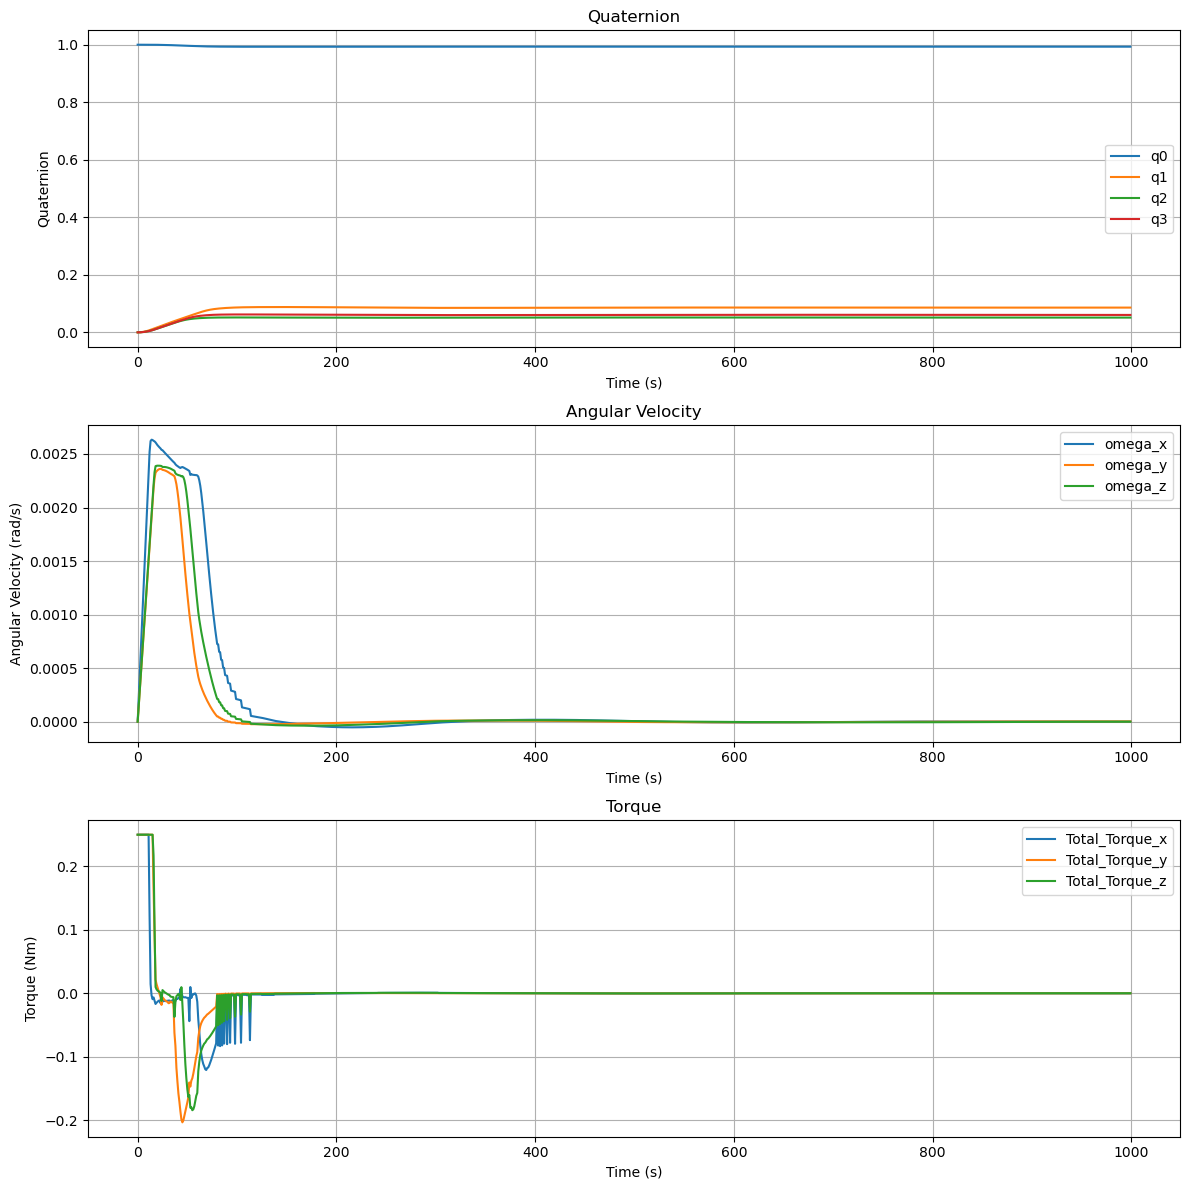

In [9]:
# Load the data from the CSV file
data = pd.read_csv('satellite_attitude_control_RK4_maxW_Tbounds_2024-08-11_22-53-06_50_10_1.csv')

# Extract the time, roll, pitch, and yaw data
time = data['time']
quaternion = data[['q0', 'q1', 'q2', 'q3']]
angular_velocity = data[['omega_x', 'omega_y', 'omega_z']]
torque = data[['Total_torque_x', 'Total_torque_y', 'Total_torque_z']]

# Plot each figure in a separate subplot
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
axs[0].plot(time, quaternion)
axs[0].set_title('Quaternion')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Quaternion')
axs[0].legend(['q0', 'q1', 'q2', 'q3'])
axs[0].grid(True)

axs[1].plot(time, angular_velocity)
axs[1].set_title('Angular Velocity')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Angular Velocity (rad/s)')
axs[1].legend(['omega_x', 'omega_y', 'omega_z'])
axs[1].grid(True)

axs[2].plot(time, torque)
axs[2].set_title('Torque')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Torque (Nm)')
axs[2].legend(['Total_Torque_x', 'Total_Torque_y', 'Total_Torque_z'])
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, t as t_distribution
from itertools import product

def quaternion_product(q, p):
    w0, x0, y0, z0 = q
    w1, x1, y1, z1 = p
    return np.array([
        w0*w1 - x0*x1 - y0*y1 - z0*z1,
        w0*x1 + x0*w1 + y0*z1 - z0*y1,
        w0*y1 - x0*z1 + y0*w1 + z0*x1,
        w0*z1 + x0*y1 - y0*x1 + z0*w1
    ])

def quaternion_conjugate(q):
    return np.array([q[0], -q[1], -q[2], -q[3]])

def quaternion_error(q, q_target):
    return quaternion_product(quaternion_conjugate(q), q_target)

def pid_control(q, omega, q_target, integral_error, prev_error, dt, Kp, Ki, Kd):
    error = 2*quaternion_error(q, q_target)[1:]  # Vector part of the quaternion error
    
    integral_error += error * dt
    derivative_error = (error - prev_error) / dt
    
    control_torque = Kp * error + Ki * integral_error + Kd * derivative_error

    return control_torque, integral_error, error

def dynamics(t, state, integral_error, prev_error, dt, I, inv_I, q_target, Kp, Ki, Kd):
    q = state[:4]
    omega = state[4:]

    q = q / np.linalg.norm(q)  # Normalize quaternion

    dqdt = 0.5 * quaternion_product(q, np.append([0], omega))
    
    control_torque, integral_error, prev_error = pid_control(q, omega, q_target, integral_error, prev_error, dt, Kp, Ki, Kd)
    
    omega_cross_I_omega = np.cross(omega, I @ omega)
    dwdt = inv_I @ (control_torque - omega_cross_I_omega)

    return np.concatenate([dqdt, dwdt]), integral_error, prev_error

def rk4_step(dynamics_func, t, state, dt, integral_error, prev_error, I, inv_I, q_target, Kp, Ki, Kd):
    k1, integral_error1, prev_error1 = dynamics_func(t, state, integral_error, prev_error, dt, I, inv_I, q_target, Kp, Ki, Kd)
    k2, integral_error2, prev_error2 = dynamics_func(t + 0.5 * dt, state + 0.5 * dt * k1, integral_error1, prev_error1, dt, I, inv_I, q_target, Kp, Ki, Kd)
    k3, integral_error3, prev_error3 = dynamics_func(t + 0.5 * dt, state + 0.5 * dt * k2, integral_error2, prev_error2, dt, I, inv_I, q_target, Kp, Ki, Kd)
    k4, integral_error4, prev_error4 = dynamics_func(t + dt, state + dt * k3, integral_error3, prev_error3, dt, I, inv_I, q_target, Kp, Ki, Kd)

    new_state = state + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    return new_state, integral_error4, prev_error4

def run_simulation(Kp, Ki, Kd, max_time=2000, dt=1, angular_velocity_bound=0.00269):
    # Initialize simulation
    Ix, Iy, Iz = 1191, 1844, 1798
    I = np.diag([Ix, Iy, Iz])
    inv_I = np.linalg.inv(I)

    q_target = np.array([0.9938, 0.086, 0.0513, 0.0608])
    q_target = q_target / np.linalg.norm(q_target)

    q0 = np.array([1, 0, 0, 0])
    q0 = q0 / np.linalg.norm(q0)
    omega0 = np.array([0, 0, 0])
    state0 = np.concatenate([q0, omega0])

    t_eval = np.arange(0, max_time, dt)
    
    integral_error = np.zeros(3)
    prev_error = np.zeros(3)
    
    states = [state0]
    
    for t in t_eval[:-1]:
        new_state, integral_error, prev_error = rk4_step(dynamics, t, states[-1], dt, integral_error, prev_error, I, inv_I, q_target, Kp, Ki, Kd)
        states.append(new_state)
        
        # Check if angular velocity exceeds the bound
        if np.any(np.abs(new_state[4:]) > angular_velocity_bound):
            return max_time, False  # Return max time and flag for exceeding bound
    
    states = np.array(states)
    omega = states[:, 4:]
    
    # Check stability
    threshold = 1e-5
    window_size = 100
    confidence = 0.97
    
    omega_avg = np.array([
        np.convolve(omega[:, i], np.ones(window_size) / window_size, mode='valid')
        for i in range(3)
    ]).T
    
    omega_sem = np.array([
        np.array([sem(omega[j:j + window_size, i]) for j in range(len(omega) - window_size + 1)])
        for i in range(3)
    ]).T
    
    degrees_freedom = window_size - 1
    confidence_factor = t_distribution.ppf((1 + confidence) / 2., degrees_freedom)
    omega_ci = omega_sem * confidence_factor
    
    for i in range(len(omega_avg)):
        if (np.all(np.abs(omega_avg[i]) < threshold) and
            np.all(omega_ci[i] < threshold)):
            return (i + window_size - 1) * dt, True  # Return stabilization time and success flag
    
    return max_time, True  # If not stabilized, return max time and success flag

def optimize_pid_gains():
    # Define the range for each gain
    kp_range = np.linspace(0, 1.0, 100)
    ki_range = np.linspace(0.000001, 0.00001, 5)
    kd_range = np.linspace(50.0, 500.0, 100)
    
    best_time = float('inf')
    best_gains = None
    
    total_combinations = len(kp_range) * len(ki_range) * len(kd_range)
    current_combination = 0
    
    valid_solutions = 0
    exceeded_velocity_bound = 0
    didnt_stabilize = 0

    for kp, ki, kd in product(kp_range, ki_range, kd_range):
        current_combination += 1
        print(f"Testing combination {current_combination}/{total_combinations}")
        
        Kp = np.array([kp, kp, kp])
        Ki = np.array([ki, ki, ki])
        Kd = np.array([kd, kd, kd])
        
        stabilization_time, within_bound = run_simulation(Kp, Ki, Kd)
        
        if within_bound:
            if stabilization_time < 2000:  # max_time
                valid_solutions += 1
                if stabilization_time < best_time:
                    best_time = stabilization_time
                    best_gains = (Kp, Ki, Kd)
            else:
                didnt_stabilize += 1
        else:
            exceeded_velocity_bound += 1

    print(f"Valid solutions: {valid_solutions}")
    print(f"Solutions that exceeded velocity bound: {exceeded_velocity_bound}")
    print(f"Solutions that didn't stabilize in time: {didnt_stabilize}")
        
    return best_gains, best_time

# Run the optimization
best_gains, best_time = optimize_pid_gains()

if best_gains is not None:
    print(f"Best gains: Kp = {best_gains[0]}, Ki = {best_gains[1]}, Kd = {best_gains[2]}")
    print(f"Best stabilization time: {best_time} seconds")
else:
    print("No valid solution found. All tested combinations either exceeded the angular velocity bound or didn't stabilize within the maximum time.")

Testing combination 1/50000
Testing combination 2/50000
Testing combination 3/50000
Testing combination 4/50000
Testing combination 5/50000
Testing combination 6/50000
Testing combination 7/50000
Testing combination 8/50000
Testing combination 9/50000
Testing combination 10/50000
Testing combination 11/50000
Testing combination 12/50000
Testing combination 13/50000
Testing combination 14/50000
Testing combination 15/50000
Testing combination 16/50000
Testing combination 17/50000
Testing combination 18/50000
Testing combination 19/50000
Testing combination 20/50000
Testing combination 21/50000
Testing combination 22/50000
Testing combination 23/50000
Testing combination 24/50000
Testing combination 25/50000
Testing combination 26/50000
Testing combination 27/50000
Testing combination 28/50000
Testing combination 29/50000
Testing combination 30/50000
Testing combination 31/50000
Testing combination 32/50000
Testing combination 33/50000
Testing combination 34/50000
Testing combination 35/

Code for making graphs and finding stability time 

| TEST                                | Data Files PID                                                                                          | Data Files MPC                                                                                         |
|-------------------------------------|---------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| Attitude Maneuver Manual tune        | [satellite_attitude_control_PID_RK4_MANTuned_P2P_2024-08-13_22-42-11.csv](#)                              | [satellite_attitude_control_RK4_maxW_Tbounds_2024-08-11_22-53-06_50_10_1.csv](#)                         |
| Attitude Maneuver optimiser tuned    | [satellite_attitude_control_PID_RK4_p2p_Optimised_2024-08-14_18-37-13.csv](#)                          | [satellite_attitude_control_MPC_RK4_P2P_OptimiserParameters_2024-08-14_11-24-39.csv](#)                  |
| Att Maneuver + external torque (10^-4) | [satellite_attitude_control_PID_RK4_Tuned_External_torques_2024-08-13_22-39-52.csv](#)                    | [satellite_attitude_control_MPC_External_torque_10e-4_2024-08-14_11-47-28.csv](#)                        |
| Att Maneuver + external torque (10^-2) | [satellite_attitude_control_PID_RK4_Tuned_External_torques_Large_0.01Nm_2024-08-14_09-04-37.csv](#)       | [satellite_attitude_control_MPC_External_torque_10e2_2024-08-14_12-03-50.csv](#)                         |
| Stationary + External torque (10^-4) | [satellite_attitude_control_PID_RK4_Tuned_External_torques_NoManuever_2024-08-14_09-14-22.csv](#)         | [satellite_attitude_control_MPC_External_torque_10e2_Norotation_2024-08-14_12-18-13.csv](#)              |
| Detumbling                           | [satellite_attitude_control_PID_RK4_Detumble_withBounds_2024-08-14_11-16-45.csv](#)                        | [satellite_attitude_control_MPC_RK4_Detumble_withBounds_2024-08-14_11-19-13.csv](#)                      |


The system stabilizes at time step: 1476 seconds


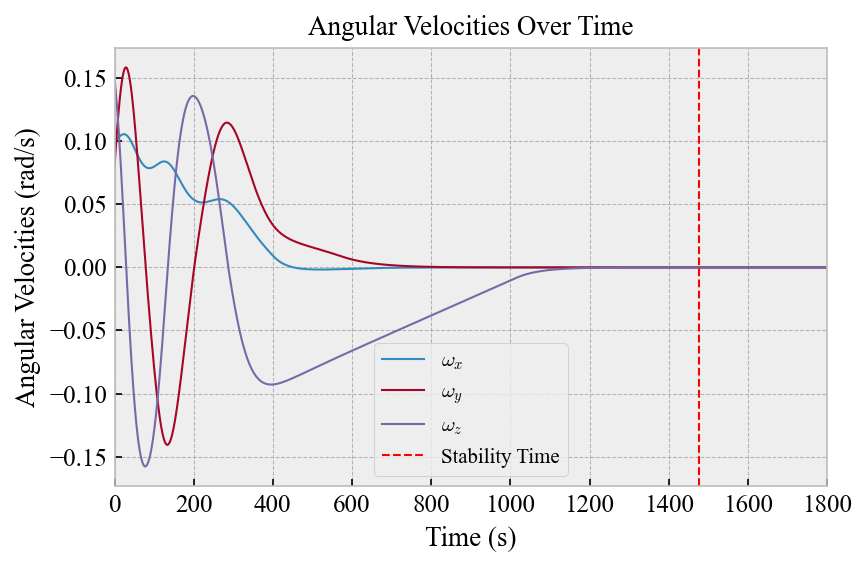

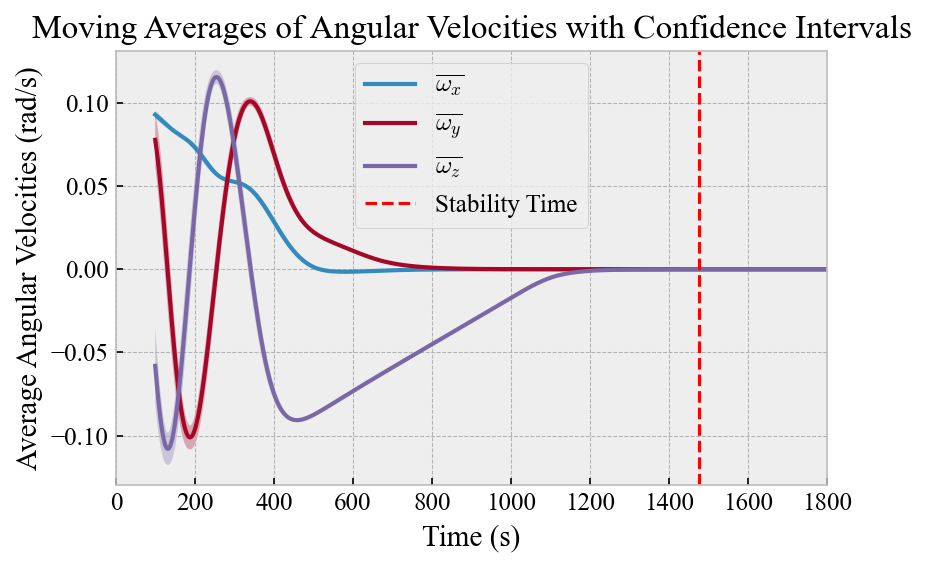

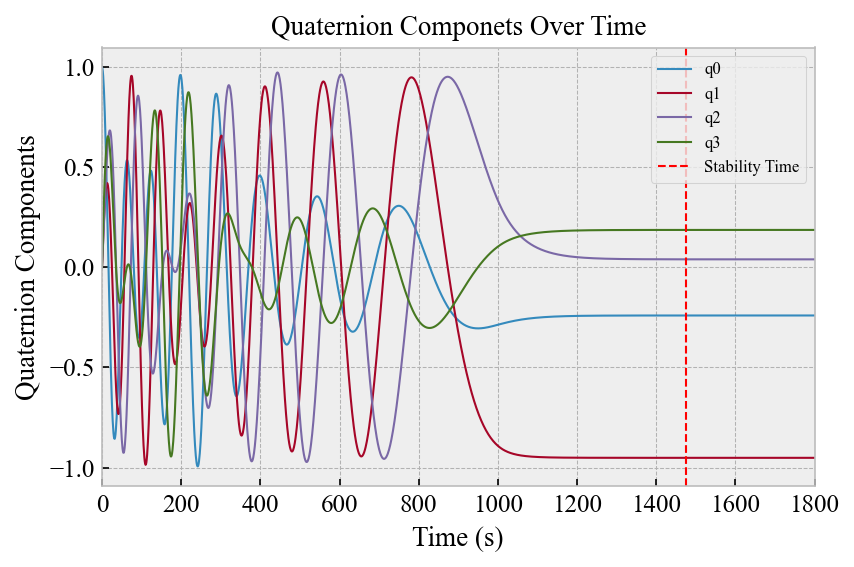

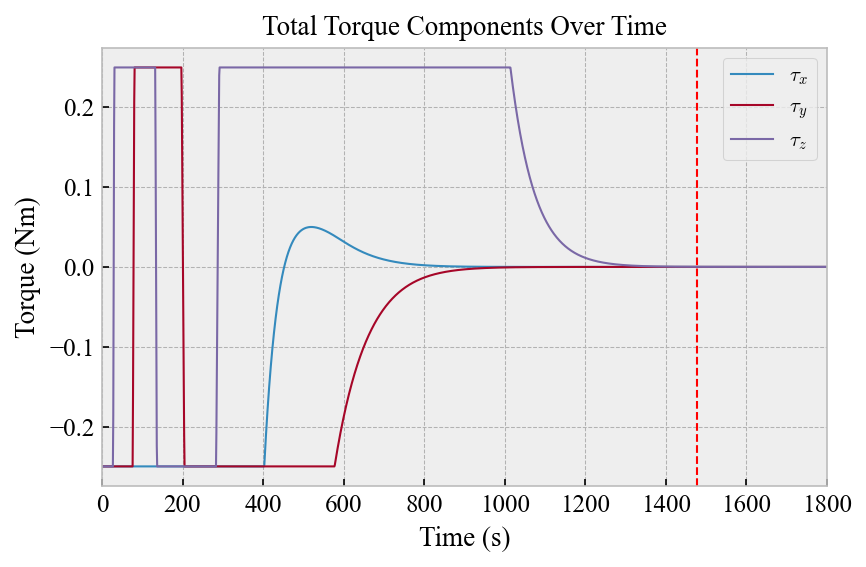

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import sem, t

# Load the CSV data
df = pd.read_csv('satellite_attitude_control_PID_RK4_Detumble_withBounds_2024-08-14_11-16-45.csv')

# Parameters
threshold = 1e-5
window_size = 100
confidence = 0.97

# Calculate moving averages
df['omega_x_avg'] = df['omega_x'].rolling(window=window_size).mean()
df['omega_y_avg'] = df['omega_y'].rolling(window=window_size).mean()
df['omega_z_avg'] = df['omega_z'].rolling(window=window_size).mean()

# Calculate standard errors of the mean (SEM)
df['omega_x_sem'] = df['omega_x'].rolling(window=window_size).apply(sem)
df['omega_y_sem'] = df['omega_y'].rolling(window=window_size).apply(sem)
df['omega_z_sem'] = df['omega_z'].rolling(window=window_size).apply(sem)

# Calculate confidence intervals
degrees_freedom = window_size - 1
confidence_factor = t.ppf((1 + confidence) / 2., degrees_freedom)

df['omega_x_ci'] = df['omega_x_sem'] * confidence_factor
df['omega_y_ci'] = df['omega_y_sem'] * confidence_factor
df['omega_z_ci'] = df['omega_z_sem'] * confidence_factor

# Check when values are within threshold
def check_stability_with_ci(df, threshold, window_size):
    for i in range(window_size, len(df)):
        if (abs(df['omega_x_avg'][i]) < threshold and df['omega_x_ci'][i] < threshold and
            abs(df['omega_y_avg'][i]) < threshold and df['omega_y_ci'][i] < threshold and
            abs(df['omega_z_avg'][i]) < threshold and df['omega_z_ci'][i] < threshold):
            return df['time'][i], i
    return -1, -1

stable_time_step, stable_index = check_stability_with_ci(df, threshold, window_size)

print(f"The system stabilizes at time step: {stable_time_step} seconds")

# Set general plot style
plt.style.use('bmh')
plt.rcParams['figure.dpi'] = 150
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# Set professional font style and size globally
plt.rcParams.update({
    'font.family': 'serif',  # Use a serif font
    'font.serif': ['Times New Roman'],  # Set Times New Roman as the preferred font
    'font.size': 14,  # Set the default font size
    'axes.titlesize': 18,  # Title font size
    'axes.labelsize': 16,  # Label font size
    'legend.fontsize': 12,  # Legend font size
    'xtick.labelsize': 12,  # X-axis tick label font size
    'ytick.labelsize': 12   # Y-axis tick label font size
})
# Calculate max time rounded to nearest 50
#max_time = np.ceil((stable_time_step + 100) / 50) * 50
max_time = 1800

# Plot angular velocities over time with a marker for stability time
plt.figure(figsize=(6, 4))
plt.plot(df['time'], df['omega_x'], label=r'$\omega_x$', linewidth=1)
plt.plot(df['time'], df['omega_y'], label=r'$\omega_y$', linewidth=1)
plt.plot(df['time'], df['omega_z'], label=r'$\omega_z$', linewidth=1)

if stable_time_step != -1:
    plt.axvline(x=stable_time_step, color='r', linestyle='--', label='Stability Time', linewidth=1)
    #plt.text(stable_time_step, 0, 'Stability Time', color='red', verticalalignment='bottom')
#plt.axhline(y=0.0, color='hotpink', linestyle='--', label='Omega Target', linewidth=1.3)
plt.xlabel('Time (s)', fontsize=13)
plt.ylabel(r'Angular Velocities (rad/s)', fontsize=13)
plt.title('Angular Velocities Over Time', fontsize=13)
plt.legend(fontsize=10)
plt.xlim(0, max_time)  # Limit the x-axis
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot moving averages with confidence intervals
plt.figure(figsize=(6, 4))
plt.plot(df['time'], df['omega_x_avg'], label=r'$\overline{\omega_x}$', linewidth=2)
plt.fill_between(df['time'], df['omega_x_avg'] - df['omega_x_ci'], df['omega_x_avg'] + df['omega_x_ci'], alpha=0.3)
plt.plot(df['time'], df['omega_y_avg'], label=r'$\overline{\omega_y}$', linewidth=2)
plt.fill_between(df['time'], df['omega_y_avg'] - df['omega_y_ci'], df['omega_y_avg'] + df['omega_y_ci'], alpha=0.3)
plt.plot(df['time'], df['omega_z_avg'], label=r'$\overline{\omega_z}$', linewidth=2)
plt.fill_between(df['time'], df['omega_z_avg'] - df['omega_z_ci'], df['omega_z_avg'] + df['omega_z_ci'], alpha=0.3)

if stable_time_step != -1:
    plt.axvline(x=stable_time_step, color='r', linestyle='--', label='Stability Time', linewidth=1.5)

plt.xlabel('Time (s)', fontsize=14)
plt.ylabel(r'Average Angular Velocities (rad/s)', fontsize=14)
plt.title('Moving Averages of Angular Velocities with Confidence Intervals', fontsize=16)
plt.legend(fontsize=12)
plt.xlim(0, max_time)  # Limit the x-axis
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot quaternions with a threshold time
plt.figure(figsize=(6, 4))
plt.plot(df['time'], df['q0'], label=r'$q_0$', linewidth=1)
plt.plot(df['time'], df['q1'], label=r'$q_1$', linewidth=1)
plt.plot(df['time'], df['q2'], label=r'$q_2$', linewidth=1)
plt.plot(df['time'], df['q3'], label=r'$q_3$', linewidth=1)
plt.axvline(x=stable_time_step, color='r', linestyle='--', label='Stability Time', linewidth=1)

plt.xlabel('Time (s)', fontsize=13)
plt.ylabel('Quaternion Components', fontsize=13)
#plt.ylabel('Logarithm of Quaternion', fontsize=13)
#plt.yscale('log')
# plot target quaternion q_target = np.array([0.9938, 0.086, 0.0513, 0.0608])
#plt.axhline(y=0.086, color='hotpink', linestyle='--', label='Target q0', linewidth=0.85)
#plt.axhline(y=0.0513, color='hotpink', linestyle='--', label='Target q1', linewidth=0.85)
#plt.axhline(y=0.0608, color='hotpink', linestyle='--', label='Target q2', linewidth=0.85)

#plt.text(stable_time_step - 10, 1e-3, 'Stability Time', color='red', fontsize=12,  horizontalalignment='right', verticalalignment='bottom')
#plt.text(5, df['q1'].iloc[-1], 'Target Quaternions', color='purple', fontsize=14, verticalalignment='bottom')
plt.title('Quaternion Componets Over Time', fontsize=13)
plt.legend(['q0', 'q1', 'q2', 'q3','Stability Time', 'Target Quaternion'],loc='upper right',fontsize=8)
plt.xlim(0, max_time)  # Limit the x-axis
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Add a plot for the torque
plt.figure(figsize=(6, 4))
plt.plot(df['time'], df['Total_torque_x'], label=r'Torque $x$', linewidth=1)
plt.plot(df['time'], df['Total_torque_y'], label=r'Torque $y$', linewidth=1)
plt.plot(df['time'], df['Total_torque_z'], label=r'Torque $z$', linewidth=1)
plt.axvline(x=stable_time_step, color='r', linestyle='--', label='Stability Time', linewidth=1.0)

plt.xlabel('Time (s)', fontsize=13)
plt.ylabel(r'Torque (Nm)', fontsize=13)
plt.title('Total Torque Components Over Time', fontsize=13)
#plt.legend(['$\\tau_x$', '$\\tau_y$', '$\\tau_z$', 'Stability Time'],fontsize=10)
plt.legend(['$\\tau_x$', '$\\tau_y$', '$\\tau_z$'],fontsize=10) # for zoomed in plot
plt.xlim(0, max_time)  # Limit the x-axis
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



In [20]:
# Calculate the overshoot of the quaternoin components 

q1_overshoot = (df['q1'].max() - 0.086) * 100
q2_overshoot = (df['q2'].max() - 0.0513) * 100
q3_overshoot = (df['q3'].max() - 0.0608) * 100

print(f"Overshoot of q1: {q1_overshoot:.2f}%")
print(f"Overshoot of q2: {q2_overshoot:.2f}%")
print(f"Overshoot of q3: {q3_overshoot:.2f}%")

#average overshoot

average_overshoot = (q1_overshoot + q2_overshoot + q3_overshoot) / 3
print(f"Average Overshoot: {average_overshoot:.2f}%")

Overshoot of q1: 0.20%
Overshoot of q2: 0.50%
Overshoot of q3: 0.47%
Average Overshoot: 0.39%


In [27]:
import math

x = 0.0003349176224754090
angle_radians = 2 * math.acos(w)
angle_degrees = math.degrees(angle_radians)
angle_degrees = 180 - angle_degrees
print("Rotation angle:", angle_degrees, "degrees")

Rotation angle: 0.03837873322228802 degrees


Optimiser for Detumble

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, t as t_distribution
from itertools import product

def quaternion_product(q, p):
    w0, x0, y0, z0 = q
    w1, x1, y1, z1 = p
    return np.array([
        w0*w1 - x0*x1 - y0*y1 - z0*z1,
        w0*x1 + x0*w1 + y0*z1 - z0*y1,
        w0*y1 - x0*z1 + y0*w1 + z0*x1,
        w0*z1 + x0*y1 - y0*x1 + z0*w1
    ])

def quaternion_conjugate(q):
    return np.array([q[0], -q[1], -q[2], -q[3]])

def pid_control(omega, omega_target, integral_error, prev_error, dt, Kp, Ki, Kd):
    error = omega - omega_target
    
    integral_error += error * dt
    derivative_error = (error - prev_error) / dt
    
    control_torque = Kp * error + Ki * integral_error + Kd * derivative_error

    return control_torque, integral_error, error

def dynamics(t, state, integral_error, prev_error, dt, I, inv_I, omega_target, Kp, Ki, Kd):
    q = state[:4]
    omega = state[4:]

    q = q / np.linalg.norm(q)  # Normalize quaternion

    dqdt = 0.5 * quaternion_product(q, np.append([0], omega))
    
    control_torque, integral_error, prev_error = pid_control(omega, omega_target, integral_error, prev_error, dt, Kp, Ki, Kd)
    
    omega_cross_I_omega = np.cross(omega, I @ omega)
    dwdt = inv_I @ (control_torque - omega_cross_I_omega)

    return np.concatenate([dqdt, dwdt]), integral_error, prev_error

def rk4_step(dynamics_func, t, state, dt, integral_error, prev_error, I, inv_I, omega_target, Kp, Ki, Kd):
    k1, integral_error1, prev_error1 = dynamics_func(t, state, integral_error, prev_error, dt, I, inv_I, omega_target, Kp, Ki, Kd)
    k2, integral_error2, prev_error2 = dynamics_func(t + 0.5 * dt, state + 0.5 * dt * k1, integral_error1, prev_error1, dt, I, inv_I, omega_target, Kp, Ki, Kd)
    k3, integral_error3, prev_error3 = dynamics_func(t + 0.5 * dt, state + 0.5 * dt * k2, integral_error2, prev_error2, dt, I, inv_I, omega_target, Kp, Ki, Kd)
    k4, integral_error4, prev_error4 = dynamics_func(t + dt, state + dt * k3, integral_error3, prev_error3, dt, I, inv_I, omega_target, Kp, Ki, Kd)

    new_state = state + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    return new_state, integral_error4, prev_error4

def run_simulation(Kp, Ki, Kd, max_time=5000, dt=1):
    # Initialize simulation
    Ix, Iy, Iz = 1191, 1844, 1798
    I = np.diag([Ix, Iy, Iz])
    inv_I = np.linalg.inv(I)

    omega_target = np.array([0, 0, 0])

    q0 = np.array([1, 0, 0, 0])
    q0 = q0 / np.linalg.norm(q0)
    omega0 = np.array([0.1, 0.08, 0.15])  # Initial angular velocity
    state0 = np.concatenate([q0, omega0])

    t_eval = np.arange(0, max_time, dt)
    
    integral_error = np.zeros(3)
    prev_error = np.zeros(3)
    
    states = [state0]
    
    for t in t_eval[:-1]:
        new_state, integral_error, prev_error = rk4_step(dynamics, t, states[-1], dt, integral_error, prev_error, I, inv_I, omega_target, Kp, Ki, Kd)
        states.append(new_state)

    return max_time, False  # Always return max time and failure flag

def optimize_pid_gains():
    # Define the range for each gain
    kp_range = np.linspace(0, 1, 100)
    ki_range = np.linspace(0, 0.00001, 1)
    kd_range = np.linspace(0, 1, 100)
    
    best_time = float('inf')
    best_gains = None
    
    total_combinations = len(kp_range) * len(ki_range) * len(kd_range)
    current_combination = 0
    
    valid_solutions = 0
    didnt_detumble = 0

    for kp, ki, kd in product(kp_range, ki_range, kd_range):
        current_combination += 1
        print(f"Testing combination {current_combination}/{total_combinations}")
        
        Kp = np.array([kp, kp, kp])
        Ki = np.array([ki, ki, ki])
        Kd = np.array([kd, kd, kd])
        
        detumble_time, success = run_simulation(Kp, Ki, Kd)
        
        if success:
            valid_solutions += 1
            if detumble_time < best_time:
                best_time = detumble_time
                best_gains = (Kp, Ki, Kd)
        else:
            didnt_detumble += 1

    print(f"Valid solutions: {valid_solutions}")
    print(f"Solutions that didn't detumble in time: {didnt_detumble}")
        
    return best_gains, best_time

# Run the optimization
best_gains, best_time = optimize_pid_gains()

if best_gains is not None:
    print(f"Best gains: Kp = {best_gains[0]}, Ki = {best_gains[1]}, Kd = {best_gains[2]}")
    print(f"Best detumble time: {best_time} seconds")
else:
    print("No valid solution found. All tested combinations didn't detumble within the maximum time.")


Testing combination 1/10000
Testing combination 2/10000
Testing combination 3/10000
Testing combination 4/10000
Testing combination 5/10000
Testing combination 6/10000
Testing combination 7/10000
Testing combination 8/10000
Testing combination 9/10000
Testing combination 10/10000
Testing combination 11/10000
Testing combination 12/10000
Testing combination 13/10000
Testing combination 14/10000
Testing combination 15/10000
Testing combination 16/10000
Testing combination 17/10000
Testing combination 18/10000
Testing combination 19/10000
Testing combination 20/10000
Testing combination 21/10000
Testing combination 22/10000
Testing combination 23/10000
Testing combination 24/10000
Testing combination 25/10000
Testing combination 26/10000
Testing combination 27/10000
Testing combination 28/10000
Testing combination 29/10000
Testing combination 30/10000
Testing combination 31/10000
Testing combination 32/10000
Testing combination 33/10000
Testing combination 34/10000
Testing combination 35/

External torque analysis

The system stabilizes at time step: 3291.0 seconds


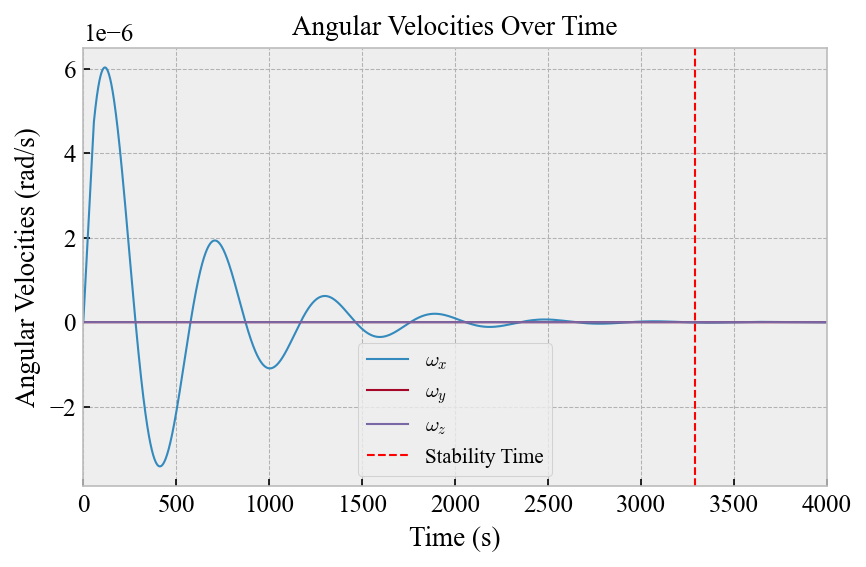

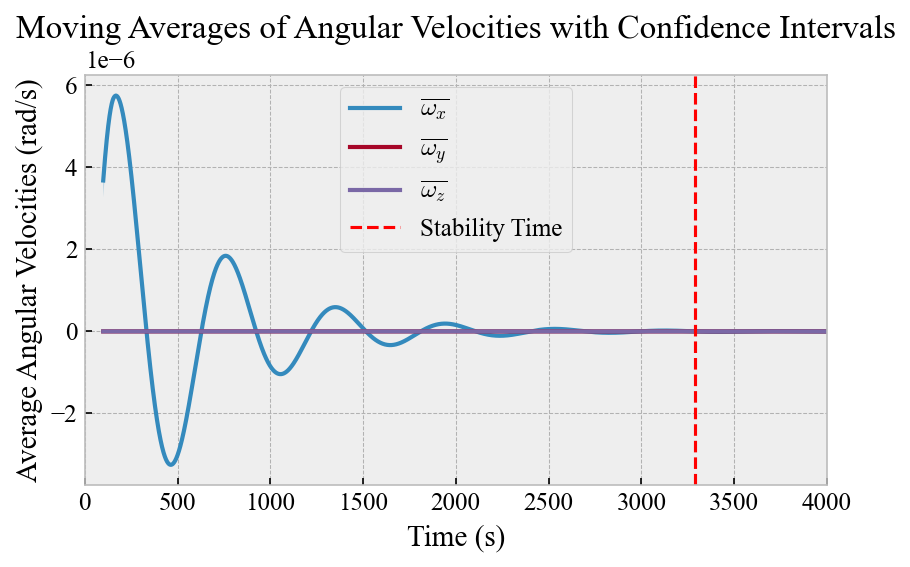

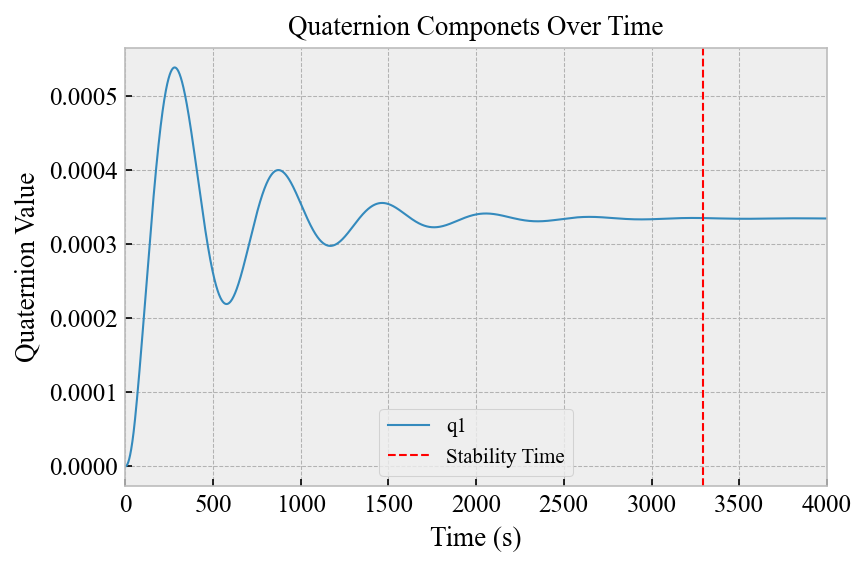

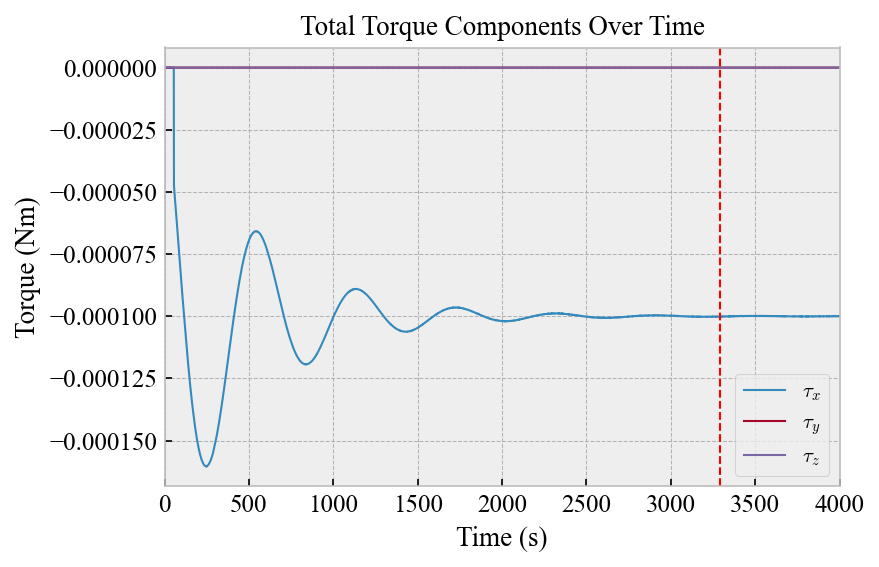

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem, t

# Load the CSV data
df = pd.read_csv('externaltorque_nomovement_MPC.csv')

# Parameters
threshold = 1e-9
window_size = 100
confidence = 0.97

# Calculate moving averages
df['omega_x_avg'] = df['omega_x'].rolling(window=window_size).mean()
df['omega_y_avg'] = df['omega_y'].rolling(window=window_size).mean()
df['omega_z_avg'] = df['omega_z'].rolling(window=window_size).mean()

# Calculate standard errors of the mean (SEM)
df['omega_x_sem'] = df['omega_x'].rolling(window=window_size).apply(sem)
df['omega_y_sem'] = df['omega_y'].rolling(window=window_size).apply(sem)
df['omega_z_sem'] = df['omega_z'].rolling(window=window_size).apply(sem)

# Calculate confidence intervals
degrees_freedom = window_size - 1
confidence_factor = t.ppf((1 + confidence) / 2., degrees_freedom)

df['omega_x_ci'] = df['omega_x_sem'] * confidence_factor
df['omega_y_ci'] = df['omega_y_sem'] * confidence_factor
df['omega_z_ci'] = df['omega_z_sem'] * confidence_factor

# Check when values are within threshold
def check_stability_with_ci(df, threshold, window_size):
    for i in range(window_size, len(df)):
        if (abs(df['omega_x_avg'][i]) < threshold and df['omega_x_ci'][i] < threshold and
            abs(df['omega_y_avg'][i]) < threshold and df['omega_y_ci'][i] < threshold and
            abs(df['omega_z_avg'][i]) < threshold and df['omega_z_ci'][i] < threshold):
            return df['time'][i], i
    return -1, -1

stable_time_step, stable_index = check_stability_with_ci(df, threshold, window_size)

print(f"The system stabilizes at time step: {stable_time_step} seconds")

# Set general plot style
plt.style.use('bmh')
plt.rcParams['figure.dpi'] = 150
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# Set professional font style and size globally
plt.rcParams.update({
    'font.family': 'serif',  # Use a serif font
    'font.serif': ['Times New Roman'],  # Set Times New Roman as the preferred font
    'font.size': 14,  # Set the default font size
    'axes.titlesize': 18,  # Title font size
    'axes.labelsize': 16,  # Label font size
    'legend.fontsize': 12,  # Legend font size
    'xtick.labelsize': 12,  # X-axis tick label font size
    'ytick.labelsize': 12   # Y-axis tick label font size
})
# Calculate max time rounded to nearest 50
#max_time = np.ceil((stable_time_step + 100) / 50) * 50
max_time = 4000

# Plot angular velocities over time with a marker for stability time
plt.figure(figsize=(6, 4))
plt.plot(df['time'], df['omega_x'], label=r'$\omega_x$', linewidth=1)
plt.plot(df['time'], df['omega_y'], label=r'$\omega_y$', linewidth=1)
plt.plot(df['time'], df['omega_z'], label=r'$\omega_z$', linewidth=1)

if stable_time_step != -1:
    plt.axvline(x=stable_time_step, color='r', linestyle='--', label='Stability Time', linewidth=1)
    #plt.text(stable_time_step, 0, 'Stability Time', color='red', verticalalignment='bottom')
#plt.axhline(y=0.0, color='hotpink', linestyle='--', label='Omega Target', linewidth=1.3)
plt.xlabel('Time (s)', fontsize=13)
plt.ylabel(r'Angular Velocities (rad/s)', fontsize=13)
plt.title('Angular Velocities Over Time', fontsize=13)
plt.legend(fontsize=10)
plt.xlim(0, max_time)  # Limit the x-axis
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot moving averages with confidence intervals
plt.figure(figsize=(6, 4))
plt.plot(df['time'], df['omega_x_avg'], label=r'$\overline{\omega_x}$', linewidth=2)
plt.fill_between(df['time'], df['omega_x_avg'] - df['omega_x_ci'], df['omega_x_avg'] + df['omega_x_ci'], alpha=0.3)
plt.plot(df['time'], df['omega_y_avg'], label=r'$\overline{\omega_y}$', linewidth=2)
plt.fill_between(df['time'], df['omega_y_avg'] - df['omega_y_ci'], df['omega_y_avg'] + df['omega_y_ci'], alpha=0.3)
plt.plot(df['time'], df['omega_z_avg'], label=r'$\overline{\omega_z}$', linewidth=2)
plt.fill_between(df['time'], df['omega_z_avg'] - df['omega_z_ci'], df['omega_z_avg'] + df['omega_z_ci'], alpha=0.3)

if stable_time_step != -1:
    plt.axvline(x=stable_time_step, color='r', linestyle='--', label='Stability Time', linewidth=1.5)

plt.xlabel('Time (s)', fontsize=14)
plt.ylabel(r'Average Angular Velocities (rad/s)', fontsize=14)
plt.title('Moving Averages of Angular Velocities with Confidence Intervals', fontsize=16)
plt.legend(fontsize=12)
plt.xlim(0, max_time)  # Limit the x-axis
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot quaternions with a threshold time
plt.figure(figsize=(6, 4))
#plt.plot(df['time'], df['q0'], label=r'$q_0$', linewidth=1)
plt.plot(df['time'], df['q1'], label=r'$q_1$', linewidth=1)
#plt.plot(df['time'], df['q2'], label=r'$q_2$', linewidth=1)
#plt.plot(df['time'], df['q3'], label=r'$q_3$', linewidth=1)
plt.axvline(x=stable_time_step, color='r', linestyle='--', label='Stability Time', linewidth=1)

plt.xlabel('Time (s)', fontsize=13)
#plt.ylabel('Quaternion Components', fontsize=13)
plt.ylabel('Quaternion Value', fontsize=13)
#plt.yscale('log')
# plot target quaternion q_target = np.array([0.9938, 0.086, 0.0513, 0.0608])
#plt.axhline(y=0.086, color='hotpink', linestyle='--', label='Target q0', linewidth=0.85)
#plt.axhline(y=0.0513, color='hotpink', linestyle='--', label='Target q1', linewidth=0.85)
#plt.axhline(y=0.0608, color='hotpink', linestyle='--', label='Target q2', linewidth=0.85)

#plt.text(stable_time_step - 10, 1e-3, 'Stability Time', color='red', fontsize=12,  horizontalalignment='right', verticalalignment='bottom')
#plt.text(5, df['q1'].iloc[-1], 'Target Quaternions', color='purple', fontsize=14, verticalalignment='bottom')
plt.title('Quaternion Componets Over Time', fontsize=13)
#plt.legend(['q0', 'q1', 'q2', 'q3','Stability Time', 'Target Quaternion'],loc='lower center',fontsize=10)
plt.legend(['q1','Stability Time'],loc = 'best',fontsize=10)
plt.xlim(0, max_time)  # Limit the x-axis
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Add a plot for the torque
plt.figure(figsize=(6, 4))
plt.plot(df['time'], df['Total_torque_x'], label=r'Torque $x$', linewidth=1)
plt.plot(df['time'], df['Total_torque_y'], label=r'Torque $y$', linewidth=1)
plt.plot(df['time'], df['Total_torque_z'], label=r'Torque $z$', linewidth=1)
plt.axvline(x=stable_time_step, color='r', linestyle='--', label='Stability Time', linewidth=1.0)

plt.xlabel('Time (s)', fontsize=13)
plt.ylabel(r'Torque (Nm)', fontsize=13)
plt.title('Total Torque Components Over Time', fontsize=13)
#plt.legend(['$\\tau_x$', '$\\tau_y$', '$\\tau_z$', 'Stability Time'],fontsize=10)
plt.legend(['$\\tau_x$', '$\\tau_y$', '$\\tau_z$'],fontsize=10) # for zoomed in plot
plt.xlim(0, max_time)  # Limit the x-axis
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

BIG O

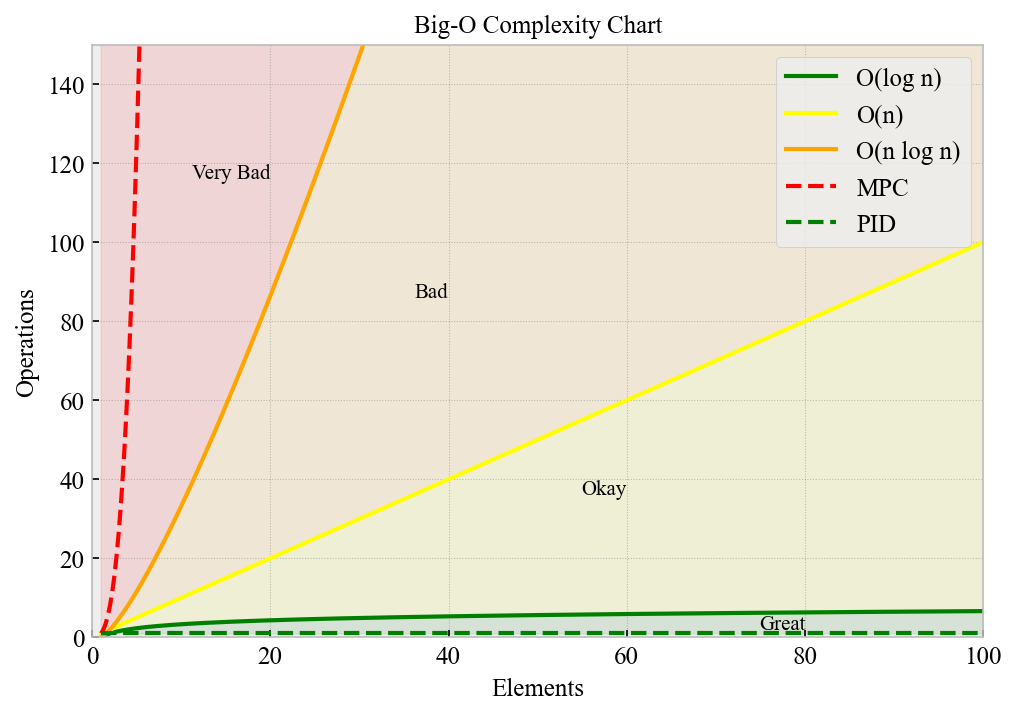

In [80]:
import numpy as np
import matplotlib.pyplot as plt

def O_1(n):
    return np.ones_like(n)

def O_log_n(n):
    return np.log2(n)

def O_n(n):
    return n

def O_n_log_n(n):
    return n * np.log2(n)

def O_n_squared(n):
    return n**2

def O_2_to_n(n):
    return 2**n

def O_n_factorial(n):
    return np.array([np.math.factorial(int(i)) if i <= 20 else np.inf for i in n])

def O_n_one():
    return np.ones(1000)

def O_1(n):
    return np.ones_like(n)

n = np.linspace(1, 100, 1000)

plt.figure(figsize=(7, 5))
#plt.plot(n, O_1(n), label='O(1)', color='green')
plt.plot(n, O_log_n(n), label='O(log n)', color='green')
plt.plot(n, O_n(n), label='O(n)', color='yellow')
plt.plot(n, O_n_log_n(n), label='O(n log n)', color='orange')
#plt.plot(n, O_n_squared(n), label='O(n^2)', color='red')
#plt.plot(n, O_2_to_n(n), label='O(2^n)', color='red')
#plt.plot(n[:100], O_n_factorial(n[:100]), label='O(n!)', color='red')
plt.plot(n, n*n*n, label='MPC', color='red', linestyle='--')
plt.plot(n, O_1(n), label='PID', color='green', linestyle='--')

plt.xlim(0, 100)
plt.ylim(0, 150)
plt.xlabel('Elements', fontsize=12)
plt.ylabel('Operations', fontsize=12)
plt.title('Big-O Complexity Chart', fontsize=12)
plt.legend(loc='upper right')

#plt.fill_between(n, 0, O_1(n), color='green', alpha=0.1)
plt.fill_between(n, O_1(n), O_log_n(n), color='green', alpha=0.1)
plt.fill_between(n, O_log_n(n), O_n(n), color='yellow', alpha=0.1)
plt.fill_between(n, O_n(n), O_n_log_n(n), color='orange', alpha=0.1)
plt.fill_between(n, O_n_log_n(n), 150, color='red', alpha=0.1)

plt.text(20, 120, 'Very Bad', color='black', ha='right', va='top', fontsize=10)
plt.text(40, 90, 'Bad', color='black', ha='right', va='top', fontsize=10)
plt.text(60, 40, 'Okay', color='black', ha='right', va='top', fontsize=10)
plt.text(80, 6, 'Great', color='black', ha='right', va='top', fontsize=10)

plt.grid(True, which='both', linestyle=':', color='gray', alpha=0.5)
plt.tight_layout()
plt.show()